## Решение задания от ABBYY (Шкунков Арсений)

В этом jupyter-ноутбуке содержится прокомментированное написание решения, работы с данными, а также обучение моделей для решения тестового задания.

После обучения лушчих моделей, они сохраняются и далее используются в скрипте predictions.py, где содержатся функции predict(path) и predict_once(text).

Помимо ноутбука также есть папки data (все данные -> / данные с википедии / маленький датасет для использования в tests.py / пример входных данных / предсказания на примере входных данных / основной датасет), nlp-data-py (клон гитхаб репозитория для парсинга страниц с википедии, куда я внес пару изменений, чтобы парсить страницы на любом языке), models (предобученные модели), а также скрипты для сбора, парсинга данных с википедии, и predictions.py, где содержатся функции predict(path) и predict_once(text).

### План работы

1. Возьмем большой датасет Old Newspaper - https://www.kaggle.com/alvations/old-newspapers, выберем из него записи на нескольких языках (английский, немецкий, русский) и создадим небольшую выборку (по 8 тысяч записей на язык). На первом этапе не будем проводить предобработку текста, а сразу воспользуемся CountVectorizer для численного представления, и обучим линейный классификатор (Logistic Regression и kNN). В конце, сравним результаты.

2. Далее возьмем сделаем большую выборку (по 25 тысяч записей на язык) и добавим еще 6 языков (суммарно: 'English', 'Russian', 'German', 'Indonesian', 'Chinese (Traditional)', 'Ukranian', 'Korean', 'Turkish', 'Polish'). Далее проведем предобработку (lowercase, токенизация), и воспользуемся TF-IFD. Обучим те же линейные классификаторы, сравним результаты.

3. Нейронные сети. Попробуем использовать самую простую RNN для решения данной задачи на выборке из прошлого пункта. Создадим словарь для всех записей из выборки и обучим RNN на нем.

4. Бонус: моя попытка распарсить википедию, и использование этих данных для обучения линейного классификатора. Результат не понравился, в связи с чем я решил искать другие данные и пришел к пункту 1.

### Загрузка и обработка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Во время работы на компьютере я использовал весь датасет old_newspaper.tsv, но так как он весит 6Gb, я не могу его полностью загрузить на GitHub.
Вместо него вы можете использовать его более легкую версию old_newspaper_light.csv из моего репозитория (тем не менее, код для его создания из исходного датасета есть в следующем пункте), либо скачать оригинал по ссылке с Kaggle https://www.kaggle.com/alvations/old-newspapers

In [2]:
corpus = pd.read_csv('data/old-newspaper.tsv', sep='\t', error_bad_lines=False)

In [ ]:
corpus = pd.read_csv('data/old_newspaper_light.сsv')

Посмотрим на данные

In [3]:
corpus.head()

,Language,Source,Date,Text
0,Afrikaans,republikein.com.na,2011/09/14,Die veranderinge aan die Britsgeboude Avensis ...
1,Afrikaans,republikein.com.na,2011/01/20,Duitsland se mans- en vrouespanne is die afgel...
2,Afrikaans,sake24.com,2009/11/28,"Mnr. Estienne de Klerk, uitvoerende direkteur ..."
3,Afrikaans,sake24.com,2009/11/12,Mustek is se finansiële-resultate-advertensie ...
4,Afrikaans,sake24.com,2011/02/04,nadat LMS se raad van trustees in Junie verled...


Посмотрим количество языков

In [4]:
corpus['Language'].value_counts()

English                 1010242
Danish                   887016
Indonesian               781521
Chinese (Simplified)     682472
Korean                   667314
                         ...   
Khmer                     55674
Nepali                    54877
Malayalam                 40484
Icelandic                 39093
Amharic                   32553
Name: Language, Length: 66, dtype: int64

Отберем только русский, английский и немецкий и посмотрим гистограмму 
количества записей на каждый из этих языков

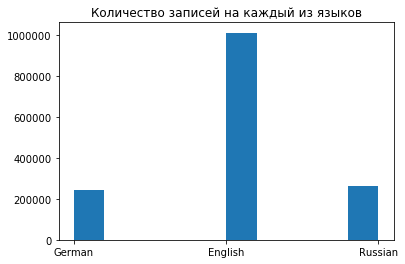

In [5]:
corpus = corpus[corpus['Language'].isin(['English', 'Russian', 'German'])]

plt.hist(corpus['Language'])
plt.title('Количество записей на каждый из языков')
plt.show()

Создадим небольшую выборку из этого датасета, уравновесив классы. Также удалим ненужные стобцы 'Source' и 'Date'

In [6]:
corpus.drop(corpus.columns[[1, 2]], axis=1, inplace=True)

size = 8000

en = corpus[corpus['Language'] == 'English'][0:size]
en_idx = corpus[corpus['Language'] == 'English'].index
corpus.drop(en_idx, inplace=True)

ru = corpus[corpus['Language'] == 'Russian'][0:size]
ru_idx = corpus[corpus['Language'] == 'Russian'].index
corpus.drop(ru_idx, inplace=True)

de = corpus[corpus['Language'] == 'German'][0:size]
de_idx = corpus[corpus['Language'] == 'German'].index
corpus.drop(de_idx, inplace=True)

corpus = corpus.combine_first(en)
corpus = corpus.combine_first(ru)
corpus = corpus.combine_first(de)

Изменим значения стобца 'Language' на 1 - русский, 0 - другие языки для дальнейшего использования в линейных моделях классификации

In [7]:
corpus.loc[corpus['Language'] == "Russian", "Language"] = 1
corpus.loc[corpus['Language'] != 1, "Language"] = 0

### 1. CountVectorizer и линейные классификаторы

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

Разделим выборку на train и test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(corpus['Text'], corpus['Language'], test_size=0.3)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

Используем CountVectorizer

In [10]:
vectorizer = CountVectorizer(max_features=1500)

X_train = vectorizer.fit_transform(X_train).toarray()
X_test  = vectorizer.fit_transform(X_test).toarray()

Обучим линейный классификатор и kNN, сделаем для них предсказания

In [11]:
model_logreg = LogisticRegression(random_state=42)
model_logreg.fit(X_train, y_train)

logreg_pred = model_logreg.predict(X_test)
logreg_pred = logreg_pred.astype('int')

model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)

knn_pred = model_knn.predict(X_test)
knn_pred = knn_pred.astype('int')

In [12]:
print('Classification Report LogReg')
print(classification_report(y_test, logreg_pred))
print()
print('Classifiaction kNN')
print(classification_report(y_test, knn_pred))

print('Accuracy LogReg:', accuracy_score(y_test, logreg_pred), 'Accuracy kNN:', accuracy_score(y_test, knn_pred))
print('F1-Score LogReg:', f1_score(y_test, logreg_pred), 'F1-Score kNN:', f1_score(y_test, knn_pred))

Classification Report LogReg
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4748
           1       0.91      0.99      0.95      2452

    accuracy                           0.96      7200
   macro avg       0.95      0.97      0.96      7200
weighted avg       0.97      0.96      0.97      7200


Classifiaction kNN
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4748
           1       0.85      0.85      0.85      2452

    accuracy                           0.90      7200
   macro avg       0.89      0.89      0.89      7200
weighted avg       0.90      0.90      0.90      7200

Accuracy LogReg: 0.9647222222222223 Accuracy kNN: 0.8970833333333333
F1-Score LogReg: 0.950293542074364 F1-Score kNN: 0.8493596259402318


Здесь видно, что обе модели показали результаты сильно близкие к 1, но этому доверять нельзя из-за количества данных, и отсутствия какой-либо предобработки.

### 2. Преобработка данных, токенизация и TF-IDF

In [2]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

Добавим больше языков. Посмотрим на общее количество строк для каждого языка.

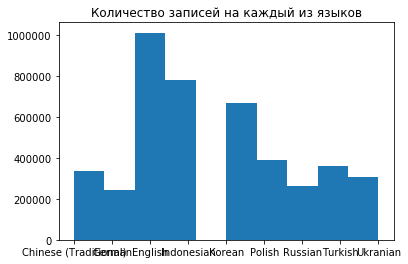

In [3]:
corpus = pd.read_csv('data/old-newspaper.tsv', sep='\t', error_bad_lines=False)
corpus = corpus[corpus['Language'].isin(['English', 'Russian', 'German', 'Indonesian', 'Chinese (Traditional)', 'Ukranian',
                                         'Korean', 'Turkish', 'Polish'])]

plt.hist(corpus['Language'])
plt.title('Количество записей на каждый из языков')
plt.show()

Уберем ненужные столбцы и составим выборку по 25 тысяч строк на каждый язык. Для русского возьмем 50 тысяч строк.

In [4]:
corpus.drop(corpus.columns[[1, 2]], axis=1, inplace=True)

In [5]:
size = 25000

languages = ['English', 'Russian', 'German', 'Indonesian', 'Chinese (Traditional)', 'Ukranian',
             'Korean', 'Turkish', 'Polish']

def select_rows(corpus, language, size):
    if language == 'Russian': size = size * 2
    lang_arr = corpus[corpus['Language'] == language][0:size]
    lang_idx = corpus[corpus['Language'] == language].index
    corpus.drop(lang_idx, inplace=True)
    corpus = corpus.combine_first(lang_arr)
    
    return corpus
    
for lang in languages:
    corpus = select_rows(corpus, lang, size)

In [6]:
corpus.to_csv('data/old_newspaper_light.csv', index=False)

Обработаем данные. Уберем лишние знаки, приведем все к нижнему регистру и разобьем каждую строку на токены. Далее разметим строки по принципу: 1 - русский язык, 0 - другие языки.

In [151]:
import string

corpus['Text'] = corpus['Text'].replace(r'[{}]'.format(string.punctuation), '', regex=True)
corpus['Text'] = [text.lower() for text in corpus['Text']]
corpus['Text'] = [word_tokenize(text) for text in corpus['Text']]

In [7]:
corpus.reset_index(inplace=True)
corpus['Language'].value_counts()

Russian                  50000
Chinese (Traditional)    25000
Indonesian               25000
Korean                   25000
Ukranian                 25000
English                  25000
Turkish                  25000
German                   25000
Polish                   25000
Name: Language, dtype: int64

In [153]:
corpus.loc[corpus['Language'] == "Russian", "Language"] = 1
corpus.loc[corpus['Language'] != 1, "Language"] = 0

corpus.drop(corpus.columns[0], axis=1, inplace=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus = corpus.astype({"Text": str})

Разобьем обработанные данные на train и test и загрузим в TF-IDF-Vectorizer. Далее создадим модели логистической регрессии и kNN, и обучим их на векторах преобразованных с помощью TF-IDF

In [155]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corpus['Text'], corpus['Language'], test_size=0.3)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [156]:
Tfidf_vect = TfidfVectorizer(max_features=25000)
Tfidf_vect.fit(corpus['Text'])
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

In [157]:
model_logreg = LogisticRegression(random_state=42)
model_logreg.fit(X_train_Tfidf, y_train)

logreg_pred = model_logreg.predict(X_test_Tfidf)
logreg_pred = logreg_pred.astype('int')

model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train_Tfidf, y_train)

knn_pred = model_knn.predict(X_test_Tfidf)
knn_pred = knn_pred.astype('int')

Посчитаем метрики и выведем результат

In [158]:
print('Classification Report LogReg')
print(classification_report(y_test, logreg_pred))
print()
print('Classifiaction kNN')
print(classification_report(y_test, knn_pred))

print('Accuracy LogReg:', accuracy_score(y_test, logreg_pred), 'Accuracy kNN:', accuracy_score(y_test, knn_pred))
print('F1-Score LogReg:', f1_score(y_test, logreg_pred), 'F1-Score kNN:', f1_score(y_test, knn_pred))

Classification Report LogReg
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     71999
           1       1.00      0.93      0.96     18001

    accuracy                           0.98     90000
   macro avg       0.99      0.96      0.97     90000
weighted avg       0.98      0.98      0.98     90000


Classifiaction kNN
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     71999
           1       0.91      0.10      0.18     18001

    accuracy                           0.82     90000
   macro avg       0.86      0.55      0.54     90000
weighted avg       0.83      0.82      0.75     90000

Accuracy LogReg: 0.9842444444444445 Accuracy kNN: 0.8177666666666666
F1-Score LogReg: 0.9591754476881443 F1-Score kNN: 0.17810072663492857


Из метрик видно, что результат у LogReg показывает очень хороший результат, 
в то время как kNN на f-мере показал крайне низкий результат.

Сохраним модель логистической регрессии и TF-IDF для дальнейшего использования. 

In [159]:
import pickle

model_filename = "logistic_regression.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model_logreg, file)
    
transformer_filename = "tf_idf_logistic_regression.pkl"
with open(transformer_filename, 'wb') as file:
    pickle.dump(Tfidf_vect, file)

In [ ]:
import os

def predict(path: str):
    # функция предсказания, path - путь к папке с текстами
    directory = os.listdir(path)
    directory = sorted(directory, key=lambda x: int(x[:-4]))
    predictions = []

    for file in directory:
        open_file = open(path + '/' + file, 'r+')
        read_file = open_file.read()
        answer = predict_once(read_file)
        predictions.append(answer)

    data_for_csv = {'File Name': directory, 'Predictions': predictions}
    results = pd.DataFrame(data=data_for_csv)
    results.to_csv('data/predictions_abbyy.csv', index=False)

In [ ]:
def predict_once(text: str):
    # функция предсказания для входной строки
    cleaned_text = text.translate(str.maketrans('', '', string.punctuation))
    cleaned_text = cleaned_text.lower()
    tokenized_text = word_tokenize(cleaned_text)
    vector = Tfidf_vect.transform(tokenized_text)
    prediction = model_logreg.predict(vector)

    return max(prediction)

In [ ]:
predict('data/data_abbyy')

### 3. Использование RNN

Используем данные из предыдущего пункта для создание csv файлов для train и test датасетов.

In [182]:
train = corpus[0:150000]
val   = corpus[150000:175000]
test  = corpus[175000:250000]

In [183]:
corpus.to_csv('data/corpus/corpus.csv', index=False)

In [184]:
train.to_csv('data/corpus/train_corpus.csv', index=False)
val.to_csv('data/corpus/val_corpus.csv', index=False)
test.to_csv('data/corpus/test_corpus.csv', index=False)

Импортируем библиотеки для дальнейшей работы

In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator, TabularDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Создадим датасет из полученных выше csv файлов, и создадим итератор. После построим словарь для train.

In [223]:
TEXT = Field()
LABEL = LabelField(dtype = torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train, val, test = TabularDataset.splits(
                        path='data/corpus/', train='train_corpus.csv',
                        validation='val_corpus.csv', test='test_corpus.csv', format='csv',
                        fields=[('Language', LABEL), ('Text', TEXT)], skip_header = True)

train_iter, val_iter, test_iter = BucketIterator.splits((train, val, test), batch_size=64, device=device, 
                                              sort_key=lambda x: len(x.Text), sort_within_batch=False,)

MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train)

In [224]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [225]:
print(TEXT.vocab.freqs.most_common(20))

[("'в',", 72839), ("'и',", 51297), ("'на',", 44469), ("'die',", 37820), ("'the',", 37256), ("'der',", 36026), ("'не',", 35345), ("'in',", 32835), ("'«',", 30404), ("'»',", 28349), ("'’',", 26697), ("'to',", 24487), ("'und',", 23396), ("'w',", 22949), ("'–',", 22775), ("'“',", 21298), ("'a',", 21281), ("'у',", 19467), ("'yang',", 18489), ("'с',", 18290)]


In [226]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1})


Напишим архитектуру самой простой реккурентной нейронной сети, функцию train и цикл обучения. Объявим и будем обучать.

In [227]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        
        return self.fc(hidden.squeeze(0))
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [228]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

Функция для вычисления accuracy для батча

In [229]:
def batch_accuracy(preds, y):
    # Считает accuracy по батчу, а после возвращает нормированную оценку

    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [230]:
def train(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.train()
    
    for batch in data:
        optimizer.zero_grad()
                
        predictions = model(batch.Text).squeeze(1)
        
        loss = criterion(predictions, batch.Language)
        
        accuracy = batch_accuracy(predictions, batch.Language)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(data), epoch_accuracy / len(data)

In [234]:
def evaluate(model, data, criterion):
    
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in data:

            predictions = model(batch.Text).squeeze(1)
            
            loss = criterion(predictions, batch.Language)
            
            accuracy = batch_accuracy(predictions, batch.Language)

            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(data), epoch_accuracy / len(data)

In [232]:
import time

def epoch_time(start_time, end_time):
    all_time = end_time - start_time
    mins = int(all_time / 60)
    secs = int(all_time - (mins * 60))
    return mins, secs

In [233]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_loss_values = []
valid_loss_values = []

train_accuracy_values = []
valid_accuracy_values = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_accuracy = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, val_iter, criterion)
    
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)
    train_accuracy_values.append(train_accuracy)
    valid_accuracy_values.append(valid_accuracy)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'models/recurrent_neural_network/rnn_model.pt')

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s ' 
          f'Train Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}% '
          f'Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_accuracy*100:.2f}%')

c:\users\shkun\appdata\local\programs\python\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


Epoch: 01 | Epoch Time: 1m 52s Train Loss: 0.502 | Train Acc: 79.97% Val. Loss: 0.650 |  Val. Acc: 69.15%
Epoch: 02 | Epoch Time: 2m 4s Train Loss: 0.502 | Train Acc: 80.01% Val. Loss: 0.422 |  Val. Acc: 88.70%
Epoch: 03 | Epoch Time: 2m 11s Train Loss: 0.496 | Train Acc: 80.42% Val. Loss: 0.381 |  Val. Acc: 86.73%
Epoch: 04 | Epoch Time: 2m 11s Train Loss: 0.495 | Train Acc: 80.52% Val. Loss: 0.533 |  Val. Acc: 74.80%
Epoch: 05 | Epoch Time: 2m 18s Train Loss: 0.500 | Train Acc: 80.18% Val. Loss: 0.446 |  Val. Acc: 76.86%
Epoch: 06 | Epoch Time: 2m 21s Train Loss: 0.497 | Train Acc: 80.34% Val. Loss: 0.506 |  Val. Acc: 76.41%
Epoch: 07 | Epoch Time: 2m 14s Train Loss: 0.494 | Train Acc: 80.58% Val. Loss: 0.511 |  Val. Acc: 84.53%
Epoch: 08 | Epoch Time: 2m 11s Train Loss: 0.406 | Train Acc: 84.29% Val. Loss: 0.357 |  Val. Acc: 90.67%
Epoch: 09 | Epoch Time: 2m 13s Train Loss: 0.405 | Train Acc: 82.48% Val. Loss: 0.276 |  Val. Acc: 90.47%
Epoch: 10 | Epoch Time: 2m 13s Train Loss: 0.42

Построим графики лоссов и значений метрик

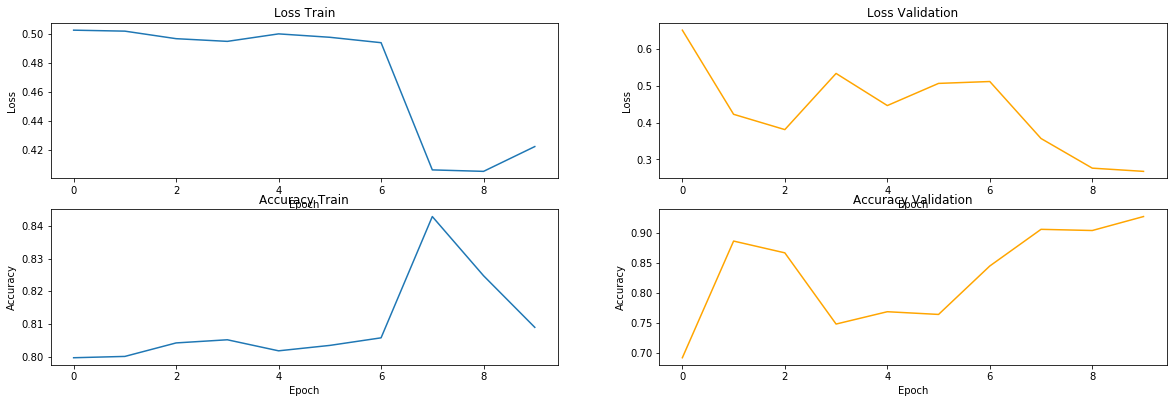

In [244]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
a1 = fig.add_subplot(621)
plt.plot(range(len(train_loss_values)), train_loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Train')

a2 = fig.add_subplot(622)
plt.plot(range(len(valid_loss_values)), valid_loss_values, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Validation')

a3 = fig.add_subplot(623)
plt.plot(range(len(train_accuracy_values)), train_accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Train')

a4 = fig.add_subplot(624)
plt.plot(range(len(valid_accuracy_values)), valid_accuracy_values, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Validation')

plt.show()

Посчитаем метрику и лосс на test

In [245]:
test_loss, test_accuracy = evaluate(model, test_iter, criterion)

In [246]:
print(test_loss, test_acc)

0.26990849657834864 0.8353961614055896


Результат получился не сильно хуже, чем у LogReg, но для использования в скрипте predictions.py на данных предоставленных в письме с тестовым заданием я выбрал LogReg.

### 4. Парсинг Wikipedia и использование полученных данных для классификации языка (изначальная идея сбора данных)

Изначально собирался использовать википедию в качестве источника данных для решения данной задачи. Нашел статью на Хабре https://habr.com/ru/post/425507/, где рассказывалось как скачивать дампы из википедии, а потом с помощью утилит WikiExtractor.py и process_wikipedia.py парсить их в CSV. 
Однако, в процессе выяснилось, чтобы парсить ее таким образом слишком долго и затратно по памяти на жестком диске (при имеющихся мощностях и времени на задачу).

Я нашел библиотеку для Python - https://github.com/madutv/nlp-wiki-data-py. Но она работала только с англоязычной 
википедией, поэтому пришлось клонировать этот репозиторий к себе и внести пару изменений в файле wiki.py, чтобы он также парсил
статьи на любом языке.

Сбор данных из википедии осуществляется через скрипт data_collection.py, а обработка и выдача csv файла с помощью data_processing.py. Далее я использую уже собранный с помощью этих скриптов csv файл.

In [210]:
wiki_train = pd.read_csv('data/wiki/wiki_train.csv')
wiki_test  = pd.read_csv('data/wiki/wiki_test.csv')

wiki_train = wiki_train.dropna(how='any') 
wiki_train = wiki_train.reset_index(drop=True)
wiki_test = wiki_test.dropna(how='any') 
wiki_test = wiki_test.reset_index(drop=True)

In [235]:
wiki_train.head()

,text,lang
0,ABBYY (/ˈʌbɪ/) — международная компания-разраб...,1.0
1,Наиболее известные продукты — программа для ра...,1.0
2,"Головные офисы ABBYY расположены в Москве, в С...",1.0
3,На 2020 год решения ABBYY используют более 50 ...,1.0
4,В апреле 2019 года консалтинговая и исследоват...,1.0


In [213]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500)
X_train = vectorizer.fit_transform(wiki_train['text']).toarray()
X_test  = vectorizer.fit_transform(wiki_test['text']).toarray()
y_train = wiki_train['lang']
y_test = wiki_test['lang']
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [214]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test = y_test.astype('int')

In [215]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      2904
           1       0.49      0.42      0.45      1491

    accuracy                           0.66      4395
   macro avg       0.61      0.60      0.60      4395
weighted avg       0.64      0.66      0.65      4395

0.655745164960182
0.4520101412531692


Как видно, метрики особо впечатляющих результатов работы модели не показали. Если потратить больше времени на парсинг и составление выборки страниц, то можно получить качество не хуже, чем полученное в предыдущих пунктах. Но от этой идеи пришлось отказаться в пользу уже размеченного датасета, чтобы больше времени уделить решению задачи и качеству решения.